# Modelo 3

### modelo de IA para prever série temporal

- Importando as bibliotecas

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit as MonteCarlo
from sklearn.preprocessing import MinMaxScaler

- Carregando o dataset

In [8]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

- Definindo as datas como indice

In [9]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

In [63]:
plt.cm.Pastel1

<module 'matplotlib.cm' from '/home/thiago_labicom/.cache/pypoetry/virtualenvs/ppgca-ds-tfinal-GEP1dTPA-py3.10/lib/python3.10/site-packages/matplotlib/cm.py'>

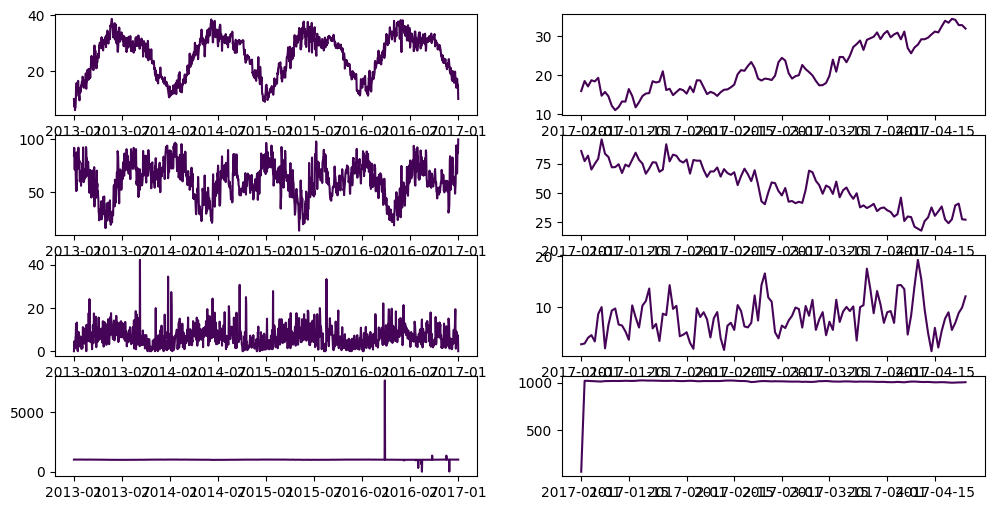

In [65]:
fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df[col],color=plt.cm.viridis(i))
    ax[i,1].plot(df_test[col],color=plt.cm.viridis(i))


- É perceptível a presença de outliers para a pressão média

/tmp/ipykernel_19440/1354816544.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(cl1,
/tmp/ipykernel_19440/1354816544.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cl2,


{'whiskers': [<matplotlib.lines.Line2D at 0x71dba5a72e90>,
 'caps': [<matplotlib.lines.Line2D at 0x71dba5a703d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x71dba5a72bf0>],
 'medians': [<matplotlib.lines.Line2D at 0x71dba5a70940>],
 'fliers': [],
 'means': []}

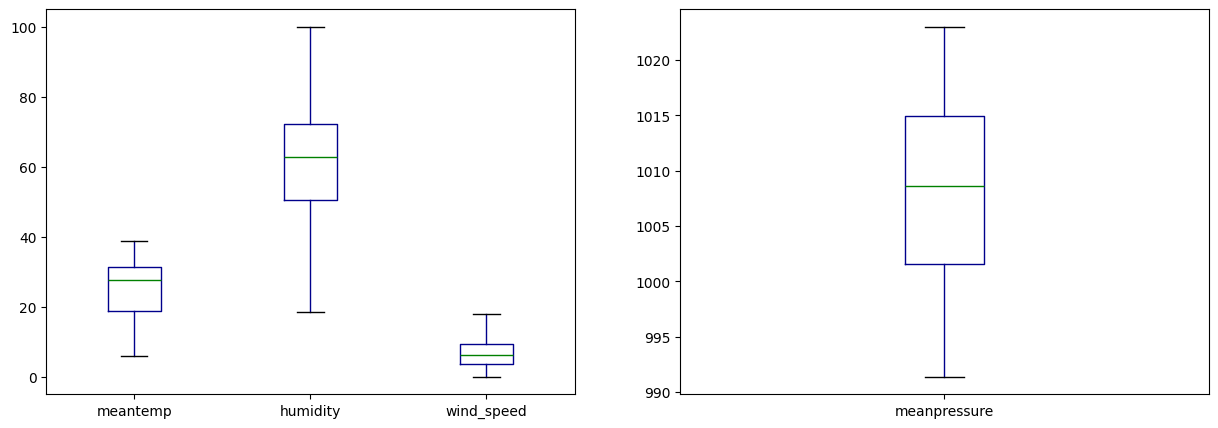

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax1.boxplot(cl1,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl1.columns,showfliers=False)

ax2.boxplot(cl2,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl2.columns,showfliers=False)
#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

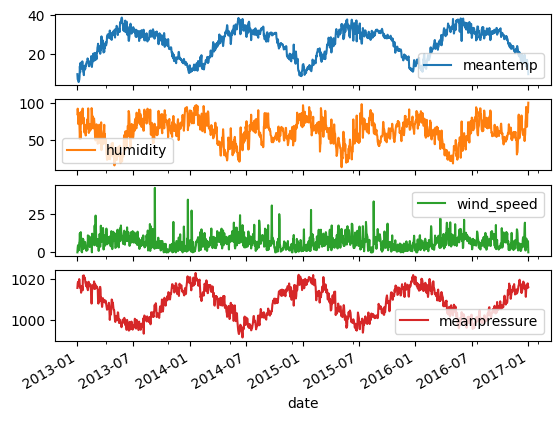

In [12]:
Q1 = df['meanpressure'].quantile(0.25)
Q3 = df['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

filter = (df['meanpressure'] >= Q1 - 1.5 * IQR) & (df['meanpressure'] <= Q3 + 1.5 *IQR)
sml1 = df.loc[filter]
sml1.plot(subplots=True)


In [13]:
cl1 = np.abs(stats.zscore(df.meanpressure))
cl1

date
2013-01-01    0.025321
2013-01-02    0.037162
2013-01-03    0.041972
2013-01-04    0.033647
2013-01-05    0.029946
                ...   
2016-12-28    0.024758
2016-12-29    0.032193
2016-12-30    0.037743
2016-12-31    0.027726
2017-01-01    0.027171
Name: meanpressure, Length: 1462, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

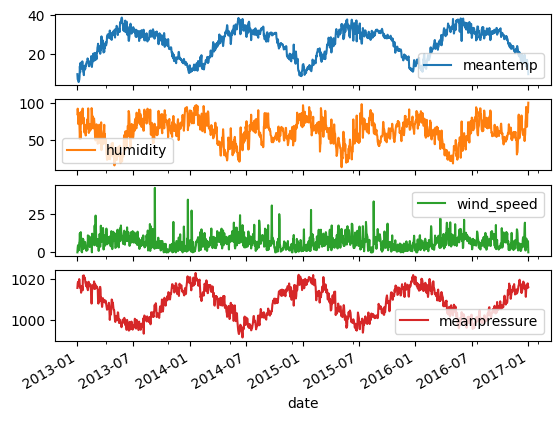

In [14]:
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)

In [15]:
diff_size1 = pd.concat([sml1,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)

nenhuma diferença no corte dos outliers em meantemperature


- Função para gerar as séries de predição

In [16]:
def create_features_labels(df, cols, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[cols].iloc[i:i+window_size].values.flatten())
        y.append(df[cols].iloc[i+window_size].values.flatten())
    return np.array(X), np.array(y)

- As variáveis de entrada são alocadas num vetor

In [24]:
scaler = MinMaxScaler()
scd_df_train  = df.copy()
scaler.fit(scd_df_train)
scd_df_train[scd_df_train.columns] = scaler.transform(scd_df_train)

scd_df_test = df_test.copy()
scd_df_test[scd_df_test.columns] = scaler.transform(scd_df_test)

scd_df_train.describe(), scd_df_test.describe()

(          meantemp     humidity   wind_speed  meanpressure
 count  1462.000000  1462.000000  1462.000000   1462.000000
 mean      0.595933     0.546868     0.161113      0.132009
 std       0.224614     0.193709     0.108044      0.023460
 min       0.000000     0.000000     0.000000      0.000000
 25%       0.393013     0.426774     0.082307      0.130770
 50%       0.663755     0.568276     0.147363      0.131679
 75%       0.773540     0.679094     0.218812      0.132509
 max       1.000000     1.000000     1.000000      1.000000,
          meantemp    humidity  wind_speed  meanpressure
 count  114.000000  114.000000  114.000000    114.000000
 mean     0.480312    0.494734    0.192893      0.131089
 std      0.194413    0.220258    0.084985      0.011647
 min      0.152838    0.049917    0.032864      0.008076
 25%      0.319041    0.302599    0.131775      0.131532
 50%      0.424127    0.511964    0.191128      0.132222
 75%      0.663483    0.675445    0.238483      0.132743
 ma

In [25]:
windows_size  = 7
n_variables = len(df.columns)

X_train, y_train = create_features_labels(scd_df_train,df.columns, window_size=windows_size)
X_test, y_test = create_features_labels(scd_df_test, df_test.columns, window_size=windows_size)
X_train[0], y_train[0]


(array([0.12227074, 0.8209571 , 0.        , 0.13260331, 0.04279476,
        0.90759076, 0.07058266, 0.132881  , 0.0356623 , 0.84983498,
        0.10974262, 0.13299381, 0.08151383, 0.66886689, 0.02921206,
        0.13279856, 0.        , 0.84790979, 0.08763619, 0.13271178,
        0.03056769, 0.80132013, 0.03505448, 0.13290703, 0.03056769,
        0.75280528, 0.14921838, 0.13316737]),
 array([0.08733624, 0.58085809, 0.16918184, 0.13300001]))

In [26]:
windows_size, n_variables

(7, 4)

- Modelagem

In [28]:
n = windows_size*n_variables
n

28

In [31]:
model = keras.Sequential()

#Camada de Input
model.add(
    keras.layers.Input((n,))
)
#Vamos manter a quantidade de neuronios proporcional ao número de entradas para facilitar o ajuste
model.add(
    keras.layers.Dense(
        n*8,
        activation='relu'
    )
)

model.add(
    keras.layers.Dense(4*n,activation='relu')
)

#Para última camada, é recomendado sigmoid
model.add(
    keras.layers.Dense(n_variables,activation='sigmoid')
)

In [37]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['r2_score']
)

In [39]:
model.fit(X_train,y_train, epochs=30, batch_size=30)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - r2_score: -0.1330
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - r2_score: 0.6130
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - r2_score: 0.0352 
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - r2_score: 0.0875 
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - r2_score: 0.6478
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0012 - r2_score: 0.3593
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0012 - r2_score: -0.5879   
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0013 - r2_score: 0.4875
Epoch 9/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0012 - r2_score: 0.4413
Epoch 10/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0012 - r2_score: -0.1035    
Epoch 11/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0012 - r2_score: 0.4328
Epoch 12/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/st